In [1]:
import concurrent.futures
import csv
import os

import cv2

#
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from skimage import color

#
# frankly plotly sucks in a jupyter environment.
# leveraging the old fashioned matplotlib for now...
# import plotly.graph_objects as go
# import plotly.io as pio

To render Matplotlib plots directly in a JupyterLab notebook, you can use the ```%matplotlib inline``` magic command. This command configures Matplotlib to render its plots inline within the Jupyter notebook cells, immediately below the code cells that produce them.  
For interactive plots within JupyterLab (e.g., for zooming and rotating 3D plots), you can use the ```%matplotlib widget``` magic instead.  
```%matplotlib widget``` requires ```ipympl``` package, ```pip install --upgrade --no-cache-dir ipympl``` if it's missing.  

In [2]:
%matplotlib widget

In [3]:
# hack to make plotly plots show up in the notebook
# pio.renderers.default = "notebook"

In [4]:
image = cv2.imread("./data/cgi/" + "01x25.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_rgb.shape
img2 = image_rgb.reshape((-1, image_rgb.shape[2]))
img2.shape

(157500, 3)

* Look at the color conversion codes here: https://docs.opencv.org/4.9.0/de/d25/imgproc_color_conversions.html  
* OpenCV Image transformation Enumerations: https://docs.opencv.org/3.4.0/d7/d1b/group__imgproc__misc.html

In [5]:
def convert_and_save(image_path, conversion_func, suffix, header):
    """
    Convert image to specified color space and save to CSV.

    Parameters:
    - image_path: Path to the original image.
    - conversion_func: Function to convert the image to the desired color space.
    - suffix: Suffix for the output CSV file name indicating the color space.
    - header: Header row for the CSV file.
    """
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image using the provided conversion function
    converted_image = conversion_func(image_rgb)

    # Flatten the image array to list pixels
    pixels = converted_image.reshape((-1, converted_image.shape[2]))
    # print('suffix: ', suffix, ' sample pixels: ', pixels[:3])

    # Save to CSV
    base_path = image_path.rsplit(".", 1)[0]
    output_path = f"{base_path}_{suffix}.csv"

    # Using NumPy to directly save to CSV
    np.savetxt(
        output_path,
        pixels,
        delimiter=",",
        header=",".join(header),
        comments="",
        encoding="utf-8",
    )

In [6]:
def image_to_color_spaces_parallel(image_path):
    """
    Convert image to various color spaces using parallel processing.
    """

    # Define conversion functions
    def to_rgb(image_rgb):
        return image_rgb

    def to_xyz(image_rgb):
        return cv2.cvtColor(image_rgb, cv2.COLOR_RGB2XYZ)

    def to_lab(image_rgb):
        return cv2.cvtColor(image_rgb, cv2.COLOR_RGB2Lab)

    def to_hsv(image_rgb):
        return cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)

    # TODO: HSL no supported in skimage.color, build support using other libraries later
    def to_hsl(image_rgb):
        return cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HLS)  # OpenCV uses HLS naming

    # Conversion specifications (function, suffix, header)
    conversions = [
        (to_rgb, "RGB", ["R", "G", "B"]),
        (to_xyz, "XYZ", ["X", "Y", "Z"]),
        (to_lab, "Lab", ["L*", "a*", "b*"]),
        (to_hsv, "HSV", ["H", "S", "V"]),
        (to_hsl, "HSL", ["H", "S", "L"]),
    ]
    for func, suff, header in conversions:
        convert_and_save(image_path, func, suff, header)

    # # Use ThreadPoolExecutor to parallelize conversions
    # with concurrent.futures.ThreadPoolExecutor() as executor:
    # 	futures = [executor.submit(convert_and_save, image_path, func, suffix, header)
    # 		for func, suffix, header in conversions]

    # # Wait for all futures to complete
    # concurrent.futures.wait(futures)

In [7]:
# Example usage
images = ["01x25.png", "02x25.png", "03x25.png", "04x25.png", "05x25.png", "06x25.png"]
for image in images:
    print("pre-processing image: ", image)
    image_path = "./data/cgi/" + image
    image_to_color_spaces_parallel(image_path)

pre-processing image:  01x25.png
pre-processing image:  02x25.png
pre-processing image:  03x25.png
pre-processing image:  04x25.png
pre-processing image:  05x25.png
pre-processing image:  06x25.png


In [17]:
# Do this for Eight-Down-Toofaan-Mail photographs as well
images = ['001.png','002.png','003.png','004.png','005.png','006.png','007.png','008.png','009.png','010.png']
for image in images:
    print("pre-processing image: ", image)
    image_path = "./data/edtf/" + image
    image_to_color_spaces_parallel(image_path)

pre-processing image:  001.png
pre-processing image:  002.png
pre-processing image:  003.png
pre-processing image:  004.png
pre-processing image:  005.png
pre-processing image:  006.png
pre-processing image:  007.png
pre-processing image:  008.png
pre-processing image:  009.png
pre-processing image:  010.png


In [8]:
# if you *HAD* to do it this way, otherwise just use markdown...or HTML
# from IPython.display import Image as IPImage

# def display_image(image_path):
#     """Display an image using IPython display."""
#     display(IPImage(filename=image_path))

In [9]:
# blows up the size of the notebook
# display_image(image_path)

Use this code:
```
![Image Title](Image Path)
```

![sample image](./data/cgi/01x25.png)

![sample image](./data/edtf/001.png)

In [10]:
def load_data_from_csv(file_path):
    """
    Load color space data from a CSV file.

    Parameters:
    - file_path: Path to the CSV file.

    Returns:
    - Numpy array of the color space data.
    """
    df = pd.read_csv(file_path)
    return df.to_numpy()

In [11]:
def convert_to_rgb(data, color_space):
    """
    Convert data from specified color space to RGB for visualization.

    Parameters:
    - data: Numpy array of the color space data.
    - color_space: The color space of the input data ('XYZ', 'Lab', 'HSV', 'HSL').

    Returns:
    - Numpy array of the data converted to RGB.
    """
    if color_space == "XYZ":
        return (
            (color.xyz2rgb(data.reshape(1, -1, 3)) * 255)
            .reshape(-1, 3)
            .astype(np.uint8)
        )
    elif color_space == "Lab":
        return (
            (color.lab2rgb(data.reshape(1, -1, 3)) * 255)
            .reshape(-1, 3)
            .astype(np.uint8)
        )
    elif color_space == "HSV":
        return (
            cv2.cvtColor(
                data.reshape(1, -1, 3).astype(np.float32), cv2.COLOR_HSV2RGB
            ).reshape(-1, 3)
            * 255
        )
    elif color_space == "HSL":
        return (
            cv2.cvtColor(
                data.reshape(1, -1, 3).astype(np.float32), cv2.COLOR_HLS2RGB
            ).reshape(-1, 3)
            * 255
        )
    else:
        return data  # Assuming RGB or already in RGB

In [12]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from skimage import color


def normalize_colors_for_plotting(data, color_space="RGB"):
    """
    Normalize color values to [0, 1] for plotting, depending on the color space.

    Parameters:
    - data: The color data to be normalized.
    - color_space: The color space of the data.

    Returns:
    - Normalized color data suitable for plotting.
    """
    if color_space in ["RGB", "HSV", "HSL"]:  # These are typically already in [0, 1]
        return data
    elif color_space == "XYZ":
        # Normalize XYZ based on typical ranges (may need adjustment based on actual data range)
        data /= np.max(data, axis=0)
    elif color_space == "Lab":
        # Normalize L in [0, 100], a and b in approximately [-110, 110]
        data = (data + [0, 110, 110]) / [100, 220, 220]
    return data


def plot_image_and_color_space(image_path, color_space="RGB"):
    """
    Plot the loaded image and its 3D point cloud in the specified color space.

    Parameters:
    - image_path: Path to the RGB image (.png format).
    - color_space: The color space for the 3D point cloud ('RGB', 'XYZ', 'Lab', 'HSV', 'HSL').
    """
    # Load and normalize the image
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB) / 255.0

    # Convert the image to the specified color space
    if color_space == "RGB":
        data = image_rgb
        axes_titles = ["R", "G", "B"]
    elif color_space == "XYZ":
        data = color.rgb2xyz(image_rgb)
        axes_titles = ["X", "Y", "Z"]
    elif color_space == "Lab":
        data = color.rgb2lab(image_rgb)
        axes_titles = ["L", "a", "b"]
    elif color_space == "HSV":
        data = color.rgb2hsv(image_rgb)
        axes_titles = ["H", "S", "V"]
    # HSL not supported yet...
    elif color_space == "HSL":
        raise ValueError("HSL not supported yet...")
    else:
        raise ValueError("Unsupported color space")

    # Normalize color values for plotting
    data_for_plotting = normalize_colors_for_plotting(data.reshape(-1, 3), color_space)

    # # Plot the image
    plt.figure(figsize=(9, 5))
    # plt.subplot needs (rows, columns, index of current plot)
    # plt.subplot(1, 2, 2)
    # plt.imshow(image_rgb)
    # plt.axis('off')
    # plt.title('Original Image')

    # Plot the 3D point cloud
    # ax = plt.subplot(1, 2, 1, projection='3d')
    # just rendering the 3d
    ax = plt.subplot(1, 1, 1, projection="3d")
    ax.scatter(
        data_for_plotting[:, 0],
        data_for_plotting[:, 1],
        data_for_plotting[:, 2],
        c=data_for_plotting,
        marker="o",
        s=0.001,
    )
    ax.set_title(f"{color_space} Color Space")
    ax.set_xlabel(axes_titles[0])
    ax.set_ylabel(axes_titles[1])
    ax.set_zlabel(axes_titles[2])

    plt.show()
    # matplotlib.pyplot.close()

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


def plot_color_space_with_rgb_colors(base_path, color_space="RGB"):
    """
    Plot the 3D point cloud for pixel data in the specified color space, colored with original RGB values.

    Parameters:
    - base_path: The base path used for saving the CSV files, without the color space suffix and .csv.
    - color_space: The color space of the data to be plotted ('XYZ', 'Lab', 'HSV', 'HSL').
    """
    # Load the color space data from CSV
    color_space_data = pd.read_csv(f"{base_path}_{color_space}.csv").to_numpy()

    # Load the corresponding RGB values from CSV
    rgb_data = pd.read_csv(f"{base_path}_RGB.csv").to_numpy()

    # Normalize RGB values to [0, 1] for matplotlib plotting
    rgb_colors = rgb_data / 255.0

    # supply axis labels
    if color_space == "RGB":
        axes_titles = ["R", "G", "B"]
    elif color_space == "XYZ":
        axes_titles = ["X", "Y", "Z"]
    elif color_space == "Lab":
        axes_titles = ["L", "a", "b"]
    elif color_space == "HSV":
        axes_titles = ["H", "S", "V"]
    # HSL not supported yet...
    elif color_space == "HSL":
        raise ValueError("HSL not supported yet...")
    else:
        raise ValueError("Unsupported color space")

    # Plot the 3D point cloud
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        color_space_data[:, 0],
        color_space_data[:, 1],
        color_space_data[:, 2],
        c=rgb_colors,
        marker="o",
        s=0.005,
    )

    ax.set_title(f"{color_space} Color Space Point Cloud Colored by RGB")
    ax.set_xlabel(axes_titles[0])
    ax.set_ylabel(axes_titles[1])
    ax.set_zlabel(axes_titles[2])

    plt.show()

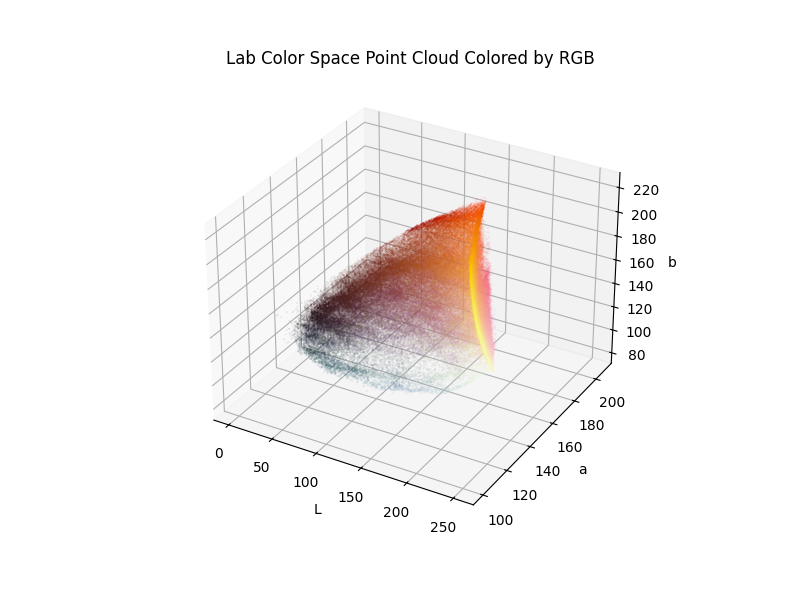

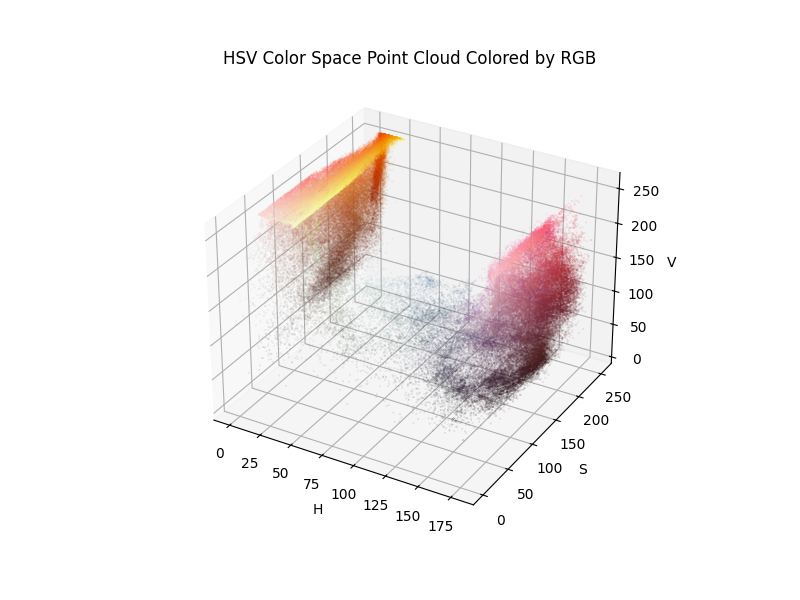

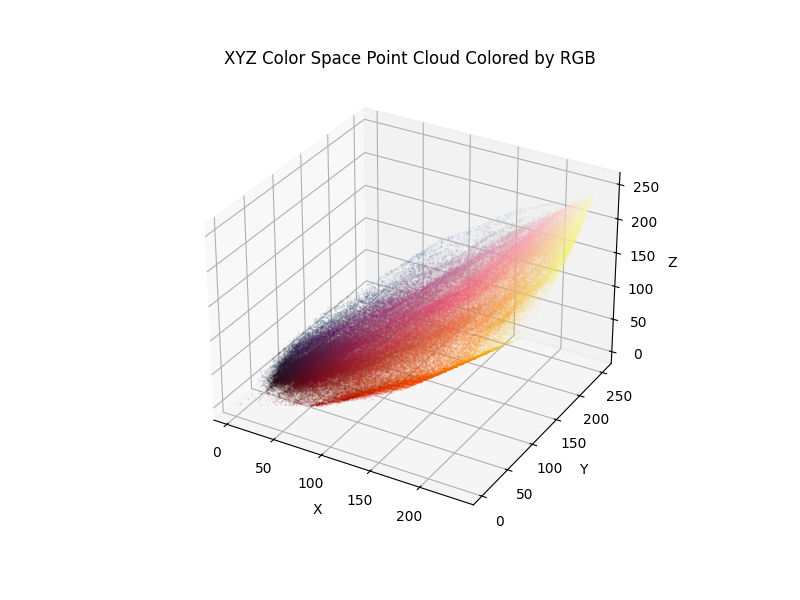

In [14]:
base_path = "./data/cgi/01x25"  # Without the color space suffix and .csv
color_space = "Lab"  # Example color space
plot_color_space_with_rgb_colors(base_path, 'Lab')
plot_color_space_with_rgb_colors(base_path, 'HSV')
plot_color_space_with_rgb_colors(base_path, 'XYZ')

In [15]:
# image_path = "./data/cgi/01x25.png"
# plot_image_and_color_space(image_path, color_space="RGB")
# plot_image_and_color_space(image_path, color_space="Lab")  # Example for CIE Lab* space
# plot_image_and_color_space(image_path, color_space="HSV")  # Example for HSV space

# # plot_image_and_color_space(image_path, color_space='HSL')  # Example for HSL space - not yet supported in skimage.color

In [16]:
# # don't do it...
# images = ["01x25.png", "02x25.png", "03x25.png", "04x25.png", "05x25.png", "06x25.png"]
# for image in images:
# 	image_path = "./data/cgi/" + image
# 	plot_image_and_color_space(image_path, color_space='RGB')
# 	plot_image_and_color_space(image_path, color_space='Lab')
# 	plot_image_and_color_space(image_path, color_space='HSV')